## Introduction 

* Nobody has heard about March Madness
* NCAA Division I championship
* 64 (+4) team single-elimination tournament
* Bracket prediction challenges are sort of popular


* Great opportunity to play with machine learning!

![](ncaa_mm.jpg)

## Dataset

* Kaggle competition: predict outcome of all possible tournament matchups
	* kaggle.com/c/march-machine-learning-mania-2017
* Convenient source of data!
* External data allowed in competition, but not used here
![](bball-logo.png)


## Dataset Details

* Results of regular season and tournament games (dating back to 1985)
    * Winning team
    * Losing team
    * Winning score
    * Losing score
* Tournament seeds for participating teams (dating back to 1985)
* Stats for winning/losing teams from regular season and tournament games (dating back to 2003)

<table border="0">
  <tr>
   <td> fgm - field goals made </td>
   <td> fga - field goals attempted </td>
  </tr> 
  <tr>
   <td> fgm3 - three pointers made </td>
   <td> fga3 - three pointers attempted </td>
  </tr> 
  <tr>
   <td> ftm - free throws made </td>
   <td> fta - free throws attempted </td>
  </tr> 
  <tr>
   <td> or - offensive rebounds </td>
   <td> dr - defensive rebounds </td>
  </tr> 
  <tr>
   <td> ast - assists </td>
   <td> to - turnovers </td>
  </tr> 
  <tr>
   <td> stl - steals </td>
   <td> blk - blocks </td>
  </tr> 
  <tr>
   <td> pf - personal fouls </td>
   <td> </td>
  </tr>
</table>

## Machine Learning Strategy

* Model input features:
    * Season average stats for each team
    * Team tournament seeds
    
* Model architecture:
	* Concatenate feature vectors for "home" and "away" team
    * Predict probability that "home" team will win
    
* Training strategy:
	* Use regular season games for training and validation -- there are far more of them
    * Use past touranment games as an independent validation set


## Calculating Season Averages (the slow way)

* Start by loading the data with pandas 
* Build a dataframe which enumerates every team for every season

In [2]:
import pandas

df_teams = pandas.read_csv('Teams.csv')
df_regular_season = pandas.read_csv('RegularSeasonDetailedResults.csv')


frames = []
for season in df_regular_season.Season.unique():
    team_season = df_teams.copy()
    team_season['season'] = season
    frames.append(team_season)

df_team_seasons = pandas.concat(frames)

df_team_seasons.head()


,Team_Id,Team_Name,season
0,1101,Abilene Chr,2003
1,1102,Air Force,2003
2,1103,Akron,2003
3,1104,Alabama,2003
4,1105,Alabama A&M,2003


In [8]:
# Stat columns for winners and losers
loser_columns = ['Lscore', 'Lfgm', 'Lfga', 'Lfgm3', 'Lfga3','Lftm', 'Lfta',
                 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf']
winner_columns = ['Wscore', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3', 'Wftm', 'Wfta',
                  'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf']
renamed_columns = [column[1:] for column in winner_columns]

season_averages = []
# Iterate over team/season pairs
for index, row in df_team_seasons.iterrows():
    # Indices which represent winning and losing game for team/season
    wins = df_regular_season.Wteam == row.Team_Id
    loses = df_regular_season.Lteam == row.Team_Id
    right_season = df_regular_season.Season == row.season

    # Extract wins for team/season, rename columns
    won_games = df_regular_season[right_season & wins][winner_columns]
    won_games.columns = renamed_columns
    # Extract losses for team/season, rename columns
    lost_games = df_regular_season[right_season & loses][loser_columns]
    lost_games.columns = renamed_columns

    # Concatenate wins and losses, calculate mean of all columns
    games = pandas.concat([won_games, lost_games]).mean()

    # Add ID columns, calculate averages, reshape into one-row dataframe
    games['Team_Id'] = row.Team_Id
    games['Season'] = row.season
    games['Team_Name'] = row.Team_Name
    games = games.to_frame().transpose()
    season_averages.append(games)

# Concatenate all the dataframes
season_averages = pandas.concat(season_averages).dropna()


## Calculating Season Averages (now with more speed)

* The above method techically works... but it takes roughly 26 seconds to run
* Same calculation possible using pandas groupby/agg
	* Highly optimized
    * Less error prone
    * More fun!


In [6]:
# Season and team are IDs, the rest are stats
loss_cols = ['Season', 'Lteam', 'Lscore', 'Lfgm', 'Lfga', 'Lfgm3', 'Lfga3',
             'Lftm', 'Lfta', 'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk',
             'Lpf']
win_cols = ['Season', 'Wteam', 'Wscore', 'Wfgm', 'Wfga', 'Wfgm3', 'Wfga3',
            'Wftm', 'Wfta', 'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk',
            'Wpf']

# Once we select columsn, we want to drop "W" and "L"... stats are stats
renamed_cols = [col[1:] if col.startswith("W") else col for col in win_cols]

# Select and rename columns en masse
df_win = df_regular_season[win_cols].copy()
df_win.columns = renamed_cols

df_loss = df_regular_season[loss_cols].copy()
df_loss.columns = renamed_cols

# Concatenate just two dataframes instead of one for each team
df_all = pandas.concat([df_win, df_loss])

# Calculate season average with groupby/agg
df_mean = df_all.groupby(["Season", 'team'], as_index=False).agg("mean")

## Slow vs. Fast

* We've replaced the iteration over team/season in python with pandas groupby/agg
* Loops in python code incur overhead from the interpreter
* Implementations of groupby/agg written in C and highly optimized (all hail Wes)


* Rule of thumb: avoid loops over 
* `map()`/`lambda` doesn't count as eliminating loops... `lambdas` still hit the interpreter

##  Merge seeds

* We want to use the seeds as features in addition to season averages
* Need to merge from a separate dataframe

In [14]:
import numpy

df_seeds = pandas.read_csv("TourneySeeds.csv")

# Seed is a string which includes division, e.g. "W08"
# TIP: use built-in `str.slice()`, not map/lambda
df_seeds["Seed"] = df_seeds["Seed"].str.slice(1, 3).astype(numpy.int32)

# Add the seeds to the feature vectors 
df_features = df_mean.merge(df_seeds, how="left",
                            left_on=["team", "Season"],
                            right_on=["Team", "Season"])

# Set seeds for unseeded teams to 17 (null is result of merge)
# TIP: use double index in `.loc[]`, not two index operations
df_features.loc[df_features["Seed"].isnull(), "Seed"] = 17

# We don't need the team name string in the feature vectors
del df_features["Team"]


df_features.head()


,Season,team,score,fgm,fga,fgm3,fga3,ftm,fta,or,dr,ast,to,stl,blk,pf,Seed
0,2003,1102,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,17.0
1,2003,1103,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,17.0
2,2003,1104,69.285714,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,10.0
3,2003,1105,71.769231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769,17.0
4,2003,1106,63.607143,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571,17.0


## Prepare Training Dataset

* Build dataset of matchups, concatenating "home" and "away" team feature vectors

In [98]:
# Load regular season matchups (not full stat results)
df_regular_season = pandas.read_csv("RegularSeasonCompactResults.csv")

# Extract winning and losing results for all teams
df_win = df_regular_season[["Season", "Wscore", "Wteam", "Lscore", "Lteam"]]
df_loss = df_regular_season[["Season", "Lscore", "Lteam", "Wscore", "Wteam"]]

# Rename columns to not reflect winner or loser ("home" is arbitrary)
matchup_rename_columns = ["Season", "home_score", "home_team",
                          "away_score", "away_team"]
df_win.columns = matchup_rename_columns
df_loss.columns = matchup_rename_columns

df_matchups = pandas.concat([df_win, df_loss])

df_matchups.head()

,Season,home_score,home_team,away_score,away_team
0,1985,81,1228,64,1328
1,1985,77,1106,70,1354
2,1985,63,1112,56,1223
3,1985,70,1165,54,1432
4,1985,86,1192,74,1447


### Merge/join features

In [99]:
df_matchups = df_matchups.merge(df_features, how="inner",
                                left_on=["Season", "home_team"],
                                right_on=["Season", "team"],
                                suffixes=("_", "_home"))

df_matchups = df_matchups.merge(df_features, how="inner",
                                left_on=["Season", "away_team"],
                                right_on=["Season", "team"],
                                suffixes=("_home", "_away"))

## Prepare Input Features for Training

In [106]:
from sklearn import preprocessing

# Select columns which serve as input
input_columns = [col for col in df_matchups.columns 
                 if not (col.startswith("team_")) 
                 and (col.endswith("_away") or col.endswith("_home"))]
x_unscaled = df_matchups[input_columns] 

# Normalize features (unit scale and centered at zero)
# RobustScaler takes median as center, IQR as unit range
scaler = preprocessing.RobustScaler() 
x = scaler.fit_transform(x_unscaled)

## Prepare model target/output features 

* We're doing supervised machine learning, so we need a target to predict
* Target is whether or not the "home team" will win

In [102]:
df_matchups["home_win"] = (df_matchups["home_score"] >
                           df_matchups["away_score"])

y = df_matchups["home_win"].astype(int)

## Create train/test split

In [103]:
from sklearn import model_selection 
from keras.utils import np_utils

x_train, x_test, y_train, y_test = (model_selection
                                    .train_test_split(x, y, test_size=0.2,
                                                      random_state=432,
                                                      stratify=y))

y_cat_train = np_utils.to_categorical(y_train)
y_cat_test = np_utils.to_categorical(y_test)


## Train a basic neural network


In [104]:
from keras import models
from keras import optimizers
from keras import layers

model_mlp = models.Sequential()
model_mlp.add(layers.Dense(units=100, input_dim=len(input_columns)))
model_mlp.add(layers.Dropout(rate=0.85)) # Dropout prevents overfitting 
model_mlp.add(layers.Activation('sigmoid'))
model_mlp.add(layers.Dense(units=2))
model_mlp.add(layers.Activation('softmax'))

model_mlp.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=0.001),
                  metrics=['accuracy'])

history = model_mlp.fit(x_train, y_cat_train, batch_size=10000, epochs=100,
                        verbose=0, validation_data=(x_test, y_cat_test))

## Inspect results

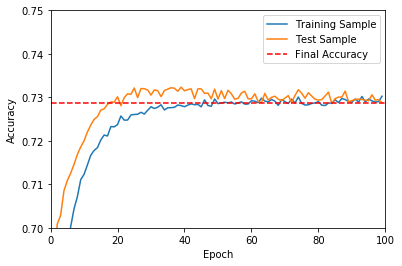

In [105]:
from matplotlib import pyplot
%matplotlib inline

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
final_accuracy = history.history['val_acc'][-1]
pyplot.axhline(final_accuracy, linestyle='--', color='r')


pyplot.ylim([0.70, 0.75])
pyplot.xlim([0, 100])
pyplot.legend(["Training Sample", "Test Sample", "Final Accuracy"])
pyplot.xlabel("Epoch")
pyplot.ylabel("Accuracy")



## Summary 

* pandas makes data manipulation easy and fast
* Explicit loops over data should be avoided
* Scikit learn has a wide variety of machine learning tools
* Keras makes nerual network usage look easy


# Backup

## Train a gradient boosted tree 

In [161]:
from sklearn import ensemble

model_gbm = ensemble.GradientBoostingClassifier(n_estimators=120,
                                                subsample=0.75,
                                                learning_rate=0.25,
                                                max_depth=3)

model_gbm.fit(x_train, y_train)

print "Accuracy: %s" % model_gbm.score(x_test, y_test)

Accuracy: 0.726439406296
